The goal here is to fix the misclassification error in the time series using our guess of the confusion matrix. We will try this on June alcohol related tweets.

In [53]:
june_key <- read.csv('C:/Users/Tom/Documents/nyu-test/alc-run/june/summary-keyword/summary/alc.csv')

In [54]:
june_key <- june_key[,'sum']

In [139]:
key_tot_df <- read.csv('C:/Users/Tom/Documents/nyu-test/alc-run/sept/summary-keyword/summary/alc_key.csv')
key_tot <- key_tot_df[,'sum']

In [140]:
key_cas_df <- read.csv('C:/Users/Tom/Documents/nyu-test/alc-run/sept/summary-keyword/summary/casual.csv')
key_cas <- key_cas_df[,'sum']

In [141]:
june_alc <- key_cas

In [142]:
june_notalc <- key_tot - key_cas

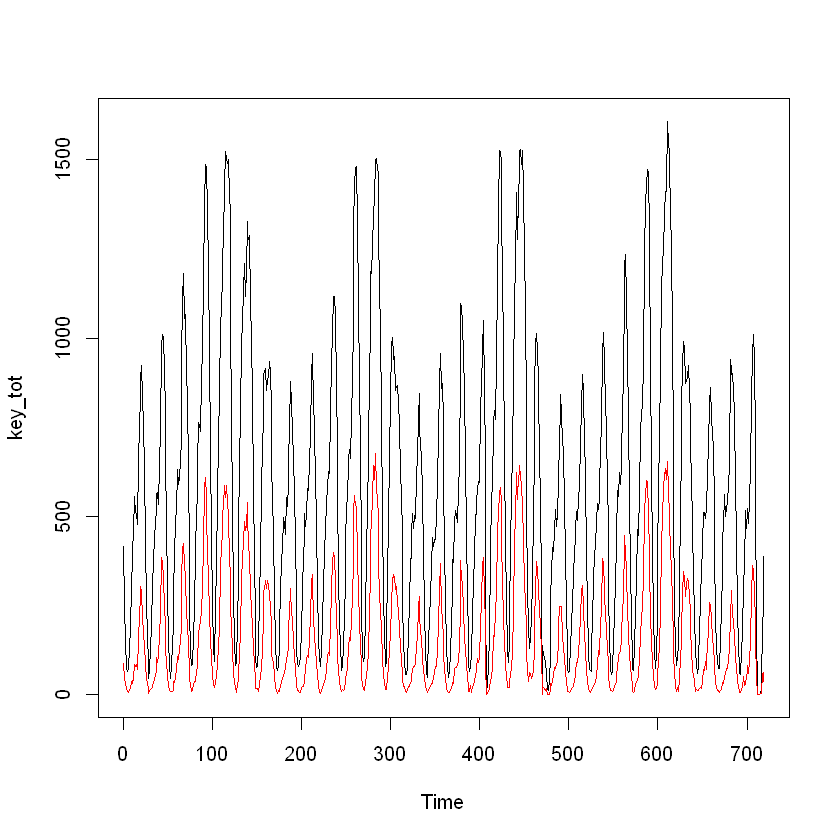

In [143]:
plot.ts(key_tot)
lines(june_alc, col='red')

In [6]:
source('c:/users/tom/pycharmprojects/nyu-research/ts.R')

Warning message:
"package 'forecast' was built under R version 3.3.3"

In [8]:
setwd('c:/users/tom/pycharmprojects/nyu-research/')

Time series output from the prediction on june:

In [6]:
june_simp <- read.csv('C:/Users/Tom/Documents/nyu-test/alc-run/june/summary/summary/alc.csv')

Note that the prediction is around 5% alcohol related, which is pretty high.

In [7]:
head(june_simp)

day,hour,sum,len
1,0,362,6004
1,1,227,3852
1,2,138,2415
1,3,81,1762
1,4,79,1648
1,5,101,2091


Seperate into alcohol and nonalcohol prediction

In [8]:
june_alc <- june_simp$sum
june_tot <- june_simp$len
june_notalc <- june_tot - june_alc

In [10]:
june_notalc <- june_tot - june_alc

A preliminary plot, black is total tweets per hour, red is predicted alcohol. 

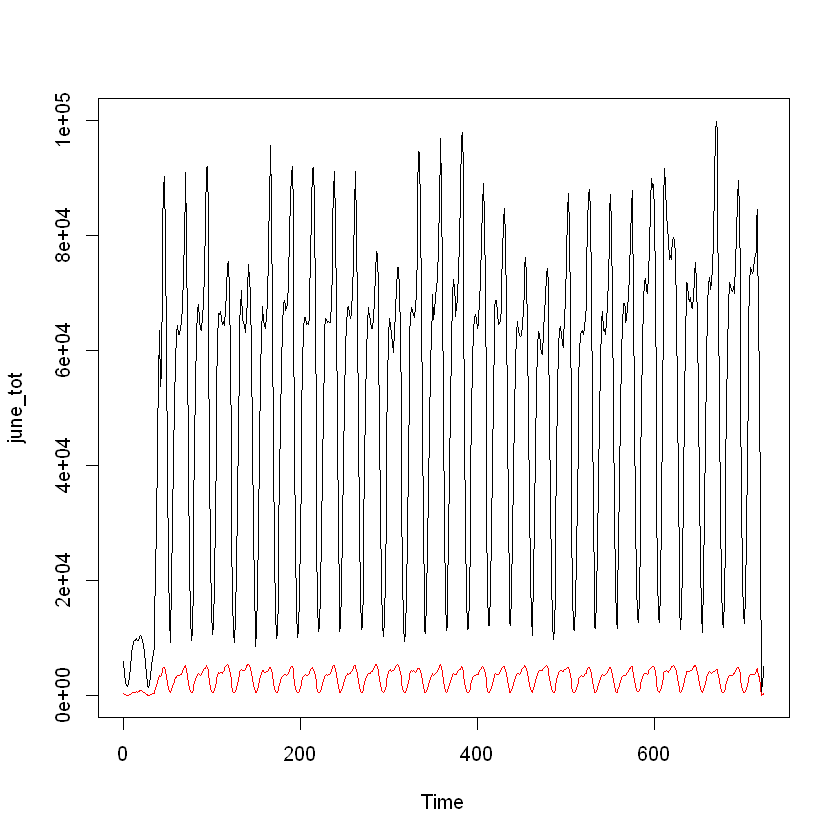

In [11]:
plot.ts(june_tot)
lines(june_alc, col='red')

This is a confusion matrix generated from cross validation and then a test on a large set of presumed non-alcohol related tweets.

In [60]:
964 + 2247

[1] 3211

In [69]:
# fpa
m_conf <- matrix(c(50/54, 4/54, 10/46, 36/46), nrow=2, ncol=2, byrow=TRUE)

In [36]:
m_conf <- matrix(c(4093/5355, 1262/5355, 1430/10295, 8865/10295), nrow=2, ncol=2, byrow=TRUE)

In [12]:
m_conf <- matrix(c(95351/100000, 4649/100000, 1430/10295, 8865/10295), nrow=2, ncol=2, byrow=TRUE)

In [70]:
rowSums(m_conf)

[1] 1 1

In [71]:
m_conf

0.9259259,0.07407407
0.2173913,0.78260870


We can write a vector equation as follows: let M = [[m00, m01, m10, m11]] be the confusion matrix, t0 = true negatives, t1 = true positives (alchol related), p0 = predicted negative, p1 = predicted positive. Hence:

[t0, t1] * M = [p0, p1]

=>

[t0, t1] = [p0, p1] * inv(M)

When we have time series, we can replace [t0, t1] and [p0, p1] by nx2 matrices representing time series, n is the number of hours, 2 is the number of classes.
We implement this to get a better guess at the true distributions.

Predicted (predict_neg, predict_pos) time series matrix.

In [144]:
v_predictions <- cbind(as.vector(june_notalc), as.vector(june_alc))

In [145]:
head(v_predictions)

328,88
205,45
118,30
58,16
56,9
63,7


Our "fixed" time series gives between 1-2% of tweets as alcohol related:

In [146]:
true_ts <- v_predictions%*%solve(m_conf)

In [147]:
true_ts[40:50,]

434.8841,98.11591
482.8705,165.12955
494.1614,245.83864
536.5636,442.43636
586.6364,422.36364
645.7295,359.27045
663.5864,246.41364
600.5659,197.43409
542.0250,110.97500
406.3500,81.65000
248.0318,42.96818


A plot of predicted alcohol (black) vs an estimated true alcohol time series (red).

In [148]:
true_ts[80:85,]

212.0727,25.927273
395.4273,8.572727
474.2795,40.720455
513.6136,43.386364
574.9159,72.084091
612.4091,151.590909


In [149]:
which.min(true_ts[,2])
min(true_ts[,2])

[1] 698

[1] -14.53182

In [150]:
true_ts[,1] = true_ts[,1] + min(true_ts[,1])
true_ts[,2] = true_ts[,2] - min(true_ts[,2])

In [151]:
min(true_ts[,2])

[1] 0

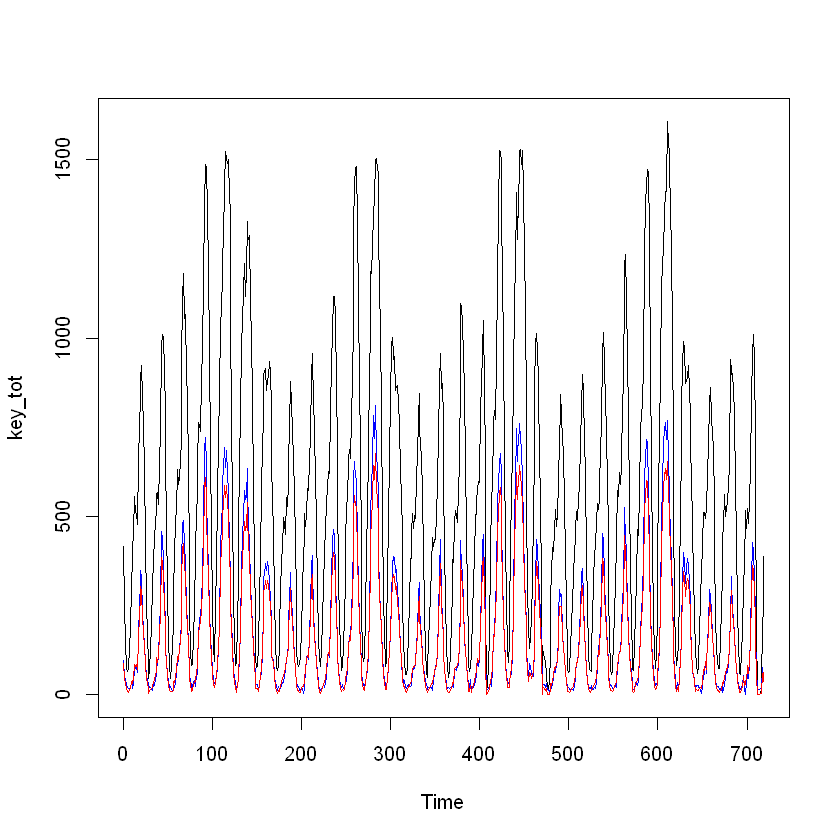

In [152]:
plot.ts(key_tot)
lines(true_ts[,2], col='blue')
lines(key_cas, col='red')
# lines(june_key, col='red')

In [153]:
key_cas_df['sum'] = true_ts[,2]
key_cas_df['len'] = true_ts[,1]

In [154]:
head(key_cas_df)

day,hour,sum,len
1,0,95.24091,335.29091
1,1,51.90682,212.62500
1,2,41.40000,121.13182
1,3,29.37727,59.15455
1,4,20.43864,59.09318
1,5,17.09318,67.43864


In [155]:
write.csv(key_cas_df, file = 'C:/Users/Tom/Documents/research/alc-summary/sept-key/casual-adj.csv', row.names=FALSE)

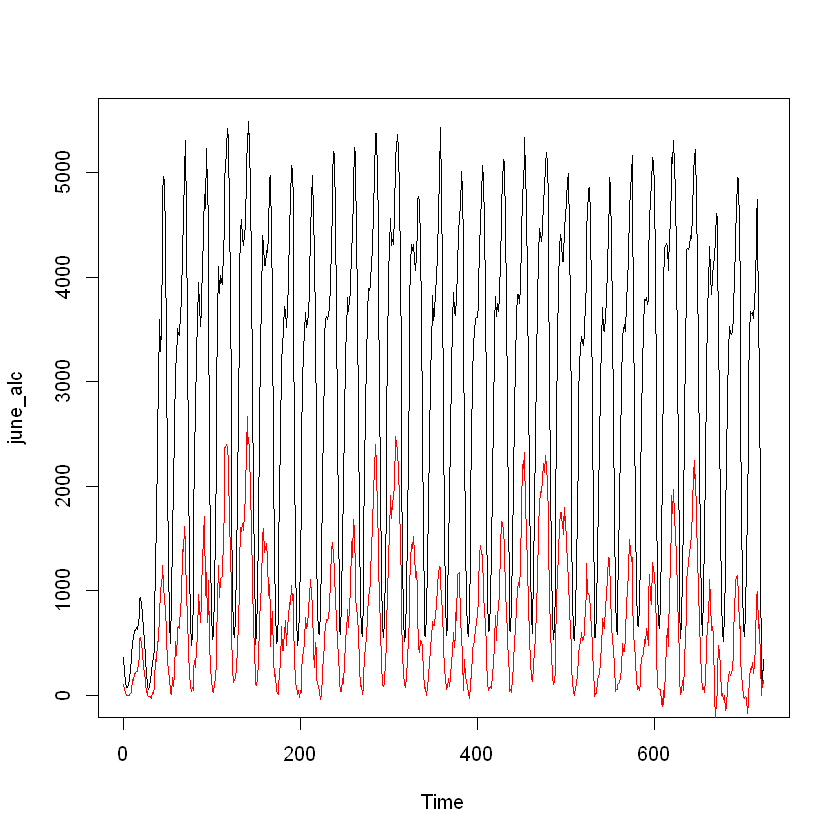

In [64]:
plot.ts(june_alc)
lines(true_ts[,2], col='red')

This looks a lot better, but one obvious problem is that some parts of the new series are slightly negative, which boils down to that the classifier makes fewer false positive predictions than suggested. However, with further fine tuning this approach looks promising! We can also validate this by using a different alcohol classfier like SVM and using the same approach.